In [1]:
import os
import re
import pandas as pd
import numpy as np
import scipy
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score, make_scorer
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [3]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [4]:
query_dir = 'queries'

In [5]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [6]:
query_client = bigquery.Client()

In [7]:
request = queries['combined_analysis_data.sql']

In [8]:
data = query_client.query(request).to_dataframe()

In [9]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3790 entries, 0 to 4239
Data columns (total 22 columns):
ad_id                 3790 non-null int64
apt_id                2622 non-null object
new_building          3790 non-null bool
num_bedrooms          3731 non-null float64
floor                 3114 non-null float64
primary_size          3790 non-null float64
total_size            3698 non-null float64
price                 3790 non-null float64
property_type         3790 non-null object
ownership_type        3790 non-null object
construction_year     3787 non-null float64
energy_character      1432 non-null object
common_expenses       883 non-null float64
brokerage_expenses    1165 non-null float64
common_wealth         637 non-null float64
common_debt           1043 non-null float64
time_s                3650 non-null float64
lat                   3650 non-null float64
lng                   3650 non-null float64
address               3790 non-null object
short_description     379

# Feature Engineering
## Energy Letter and Color

In [11]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

## Post Codes

In [12]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [13]:
data['post_code'] = data.address.apply(get_postcode_from_address)

## Settlement Names

In [14]:
post_codes_no = pd.read_csv('post_codes_no.csv', dtype={'post_code': str}).set_index('post_code')

In [15]:
post_codes_no.head()

,name,municipality_id,municipality,type
post_code,,,,
0001,OSLO,301,OSLO,P
0010,OSLO,301,OSLO,B
0015,OSLO,301,OSLO,B
0018,OSLO,301,OSLO,G
0021,OSLO,301,OSLO,P


In [16]:
post_codes_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5057 entries, 0001 to 9991
Data columns (total 4 columns):
name               5057 non-null object
municipality_id    5057 non-null int64
municipality       5057 non-null object
type               5057 non-null object
dtypes: int64(1), object(3)
memory usage: 197.5+ KB


In [17]:
data['settlement_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_no, how='left', left_on='post_code', right_index=True)['name']

## Oslo Neighborhood Names

In [18]:
post_codes_osl = pd.read_csv('post_codes.csv', dtype={'post_code':str}).set_index('post_code', drop=True)

In [19]:
post_codes_osl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0001 to 2185
Data columns (total 5 columns):
lat                  995 non-null float64
lng                  995 non-null float64
municipality         995 non-null object
neighborhood_name    940 non-null object
population           590 non-null float64
dtypes: float64(3), object(2)
memory usage: 46.6+ KB


In [20]:
data['neighborhood_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_osl, how='left', left_on='post_code', right_index=True)['neighborhood_name']

## Combine Oslo Neighborhood Names and Settlement Names

In [21]:
data['area_name'] = [s_n if s_n != 'OSLO' else n_n for s_n, n_n in zip(data['settlement_name'], data['neighborhood_name'])]

In [198]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: True if s_n == 'OSLO' else False)

# Data Imputation

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3790 entries, 0 to 4239
Data columns (total 28 columns):
ad_id                 3790 non-null int64
apt_id                2622 non-null object
new_building          3790 non-null bool
num_bedrooms          3731 non-null float64
floor                 3114 non-null float64
primary_size          3790 non-null float64
total_size            3698 non-null float64
price                 3790 non-null float64
property_type         3790 non-null object
ownership_type        3790 non-null object
construction_year     3787 non-null float64
energy_character      1432 non-null object
common_expenses       883 non-null float64
brokerage_expenses    1165 non-null float64
common_wealth         637 non-null float64
common_debt           1043 non-null float64
time_s                3650 non-null float64
lat                   3650 non-null float64
lng                   3650 non-null float64
address               3790 non-null object
short_description     379

## Impute Number Of Bedrooms

In [23]:
data['primary_size_bin'] = pd.cut(data['primary_size'], bins=[-np.inf, 30, 40, 50, 60, 70, 80, 100, 150, 200, np.inf])

In [24]:
num_bedrooms_grouping = data.groupby(['primary_size_bin'])['num_bedrooms'].median()

In [25]:
data['num_bedrooms'] = [num_bedrooms_grouping.loc[size_bin] if np.isnan(num_bedr) else num_bedr
                        for size_bin, num_bedr
                        in zip(data['primary_size_bin'], data['num_bedrooms'])]

## Impute Floor

In [26]:
data['floor'] = data['floor'].fillna(2)

## Impute Total Size

In [27]:
data['total_size'] = [primary_size if np.isnan(total_size) else total_size
                      for primary_size, total_size
                      in zip(data['primary_size'], data['total_size'])]

## Impute Construction Year

In [28]:
data['construction_year'].fillna(data[data['new_building'] == False]['construction_year'].median(), inplace=True) 

## Impute Energy Character

In [29]:
constr_year_bins = [-np.inf, 1900, 1945, 1965, 1970, 1980, 1990, 2000, 2010, np.inf]
data['construction_year_bin'] = pd.cut(data['construction_year'],
                                       bins=constr_year_bins)

In [30]:
to_plot = data.groupby(['construction_year_bin', 'energy_letter'])['energy_letter'].count()

In [31]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [32]:
energy_letter_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [33]:
def imnpute_energy_letter(letter, construction_year_bin):
    if str(letter) in 'ABCDEFG':
        return letter
    else:
        return energy_letter_grouping.loc[construction_year_bin]

In [34]:
data['energy_letter'] = [imnpute_energy_letter(letter, construction_year_bin) for letter, construction_year_bin in zip(data['energy_letter'], data['construction_year_bin'])]

In [35]:
to_plot = data.groupby(['construction_year_bin', 'energy_color'])['energy_color'].count()

In [36]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [37]:
energy_color_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [38]:
def imnpute_energy_color(color, construction_year_bin):
    if str(color) in ['mørkegrønn', 'oransje', 'lysegrønn', 'rød', 'gul']:
        return color
    else:
        return energy_color_grouping.loc[construction_year_bin]

In [39]:
data['energy_color'] = [imnpute_energy_color(color, construction_year_bin) for color, construction_year_bin in zip(data['energy_color'], data['construction_year_bin'])]

## Impute Travel Time

In [40]:
missing_transport_factor = 3
data['time_s'].fillna(data['time_s'].max() * missing_transport_factor, inplace=True)

# Mark Selected Columns

In [200]:
num_cols = ['primary_size', 'price', 'time_s', 'num_bedrooms', 'floor', 'construction_year']
cat_cols = ['property_type', 'ownership_type', 'energy_letter', 'address_oslo']
text_cols = ['short_description', 'full_description']

In [201]:
sample_size = 30

In [202]:
data_sample_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(sample_size)
                                                             if len(obj) > sample_size
                                                             else obj.sample(len(obj)))

In [203]:
num_data = data_sample_from_new_buildings[num_cols].copy()

In [204]:
cat_data = data_sample_from_new_buildings[cat_cols].copy()

In [205]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [206]:
text_data = data_sample_from_new_buildings[text_cols].copy()

# Feature Engineering

In [207]:
num_data['price_per_sq_m'] = num_data.price.div(num_data.primary_size).round(0)

In [208]:
# num_data['lat'] = num_data['lat'].round(2)
# num_data['lng'] = num_data['lng'].round(2)
# num_data['lng_x_lat'] = num_data['lng'] * num_data['lat']
# num_data['lat_pow_2'] = num_data['lat'].pow(2)
# num_data['lng_pow_2'] = num_data['lng'].pow(2)

# Predict Price With Numeric And Categorical Features

In [209]:
def draw_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return sns.lineplot(x='size', y='score', hue='type', data=curve_data)

In [210]:
def print_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = cross_validate(pipeline, X, y, scoring=score, cv=cv)
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [211]:
metrics = ['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance']
cv = 5
random_seed = 42
test_size = 0.3

In [227]:
model_data = num_data.join(cat_data)

In [228]:
model_data.dropna(inplace=True)

In [229]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3544 entries, (69757913, 10) to (151335327, 4239)
Data columns (total 25 columns):
primary_size                       3544 non-null float64
price                              3544 non-null float64
time_s                             3544 non-null float64
num_bedrooms                       3544 non-null float64
floor                              3544 non-null float64
construction_year                  3544 non-null float64
price_per_sq_m                     3544 non-null float64
property_type_Annet fritid         3544 non-null uint8
property_type_Enebolig             3544 non-null uint8
property_type_Garasje/Parkering    3544 non-null uint8
property_type_Gårdsbruk/Småbruk    3544 non-null uint8
property_type_Hytte                3544 non-null uint8
property_type_Leilighet            3544 non-null uint8
property_type_Rekkehus             3544 non-null uint8
property_type_Tomannsbolig         3544 non-null uint8
ownership_type_Andel        

In [230]:
model_data.columns

Index(['primary_size', 'price', 'time_s', 'num_bedrooms', 'floor',
       'construction_year', 'price_per_sq_m', 'property_type_Annet fritid',
       'property_type_Enebolig', 'property_type_Garasje/Parkering',
       'property_type_Gårdsbruk/Småbruk', 'property_type_Hytte',
       'property_type_Leilighet', 'property_type_Rekkehus',
       'property_type_Tomannsbolig', 'ownership_type_Andel',
       'ownership_type_Annet', 'ownership_type_Eier (Selveier)',
       'energy_letter_B', 'energy_letter_C', 'energy_letter_D',
       'energy_letter_E', 'energy_letter_F', 'energy_letter_G',
       'address_oslo_True'],
      dtype='object')

In [231]:
model_data = model_data[model_data['address_oslo_True'] == True].copy()

In [232]:
target = 'price_per_sq_m'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [233]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [234]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

In [235]:
X = model_data.drop(target, axis=1)
y = model_data[target]

In [236]:
x_cols = X.columns

In [237]:
# X = scipy.sparse.csr_matrix(X.values)

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [239]:
X_train.shape

(1122, 23)

In [240]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [241]:
estimator = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, loss='square', random_state=random_seed)

In [242]:
steps = []

# steps.append(('scale', MaxAbsScaler()))
# steps.append(('pca', PCA(n_components=10)))
steps.append(('scale', MinMaxScaler()))
steps.append(('normalize', Normalizer()))
# steps.append(('standardize', StandardScaler()))
# steps.append(('dl', KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False)))
steps.append(('ada', estimator))
# steps.append(('linear', LinearRegression()))
# steps.append(('kneighbors', KNeighborsRegressor()))
# steps.append(('bayes', ComplementNB()))
# steps.append(('mlp', MLPRegressor()))

In [243]:
pipeline = Pipeline(steps)

In [244]:
rfe = RFECV(estimator, step=1, cv=KFold(5), scoring='neg_median_absolute_error')

In [245]:
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=AdaBoostRegressor(base_estimator=None, learning_rate=0.1,
                                  loss='square', n_estimators=100,
                                  random_state=42),
      min_features_to_select=1, n_jobs=None,
      scoring='neg_median_absolute_error', step=1, verbose=0)

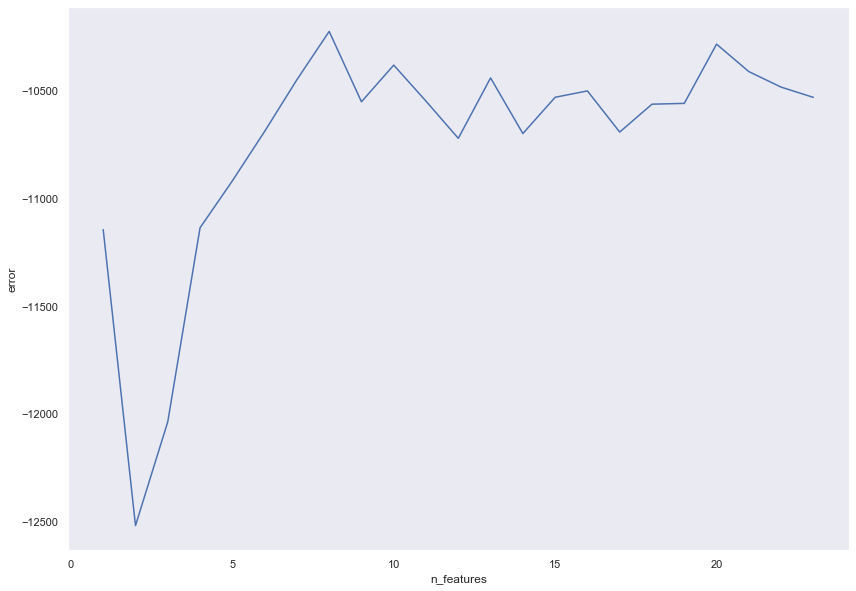

In [246]:
plt.figure()
plt.xlabel('n_features')
plt.ylabel('error')
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [247]:
feature_ranking = pd.Series(rfe.ranking_, index=x_cols)

In [248]:
feature_ranking.sort_values()

primary_size                        1
time_s                              1
num_bedrooms                        1
floor                               1
construction_year                   1
energy_letter_C                     1
ownership_type_Eier (Selveier)      1
energy_letter_G                     1
energy_letter_F                     2
property_type_Leilighet             3
ownership_type_Andel                4
ownership_type_Annet                5
property_type_Tomannsbolig          6
property_type_Garasje/Parkering     7
property_type_Enebolig              8
property_type_Annet fritid          9
energy_letter_B                    10
property_type_Gårdsbruk/Småbruk    11
energy_letter_D                    12
property_type_Hytte                13
energy_letter_E                    14
address_oslo_True                  15
property_type_Rekkehus             16
dtype: int64

In [249]:
selected_features = list(feature_ranking[feature_ranking < 9].index)

In [250]:
pipeline.fit(X_train[selected_features], y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('ada',
                 AdaBoostRegressor(base_estimator=None, learning_rate=0.1,
                                   loss='square', n_estimators=100,
                                   random_state=42))],
         verbose=False)

In [251]:
pred = pipeline.predict(X_test[selected_features])

In [252]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

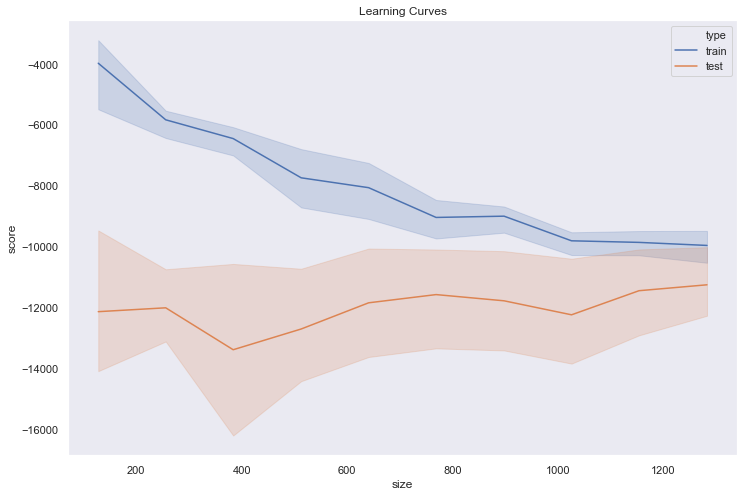

In [253]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
draw_learning_curves(pipeline, X[selected_features], y, score='neg_median_absolute_error')
plt.show()

In [254]:
print_cv_res(pipeline, X[selected_features], y, score=['neg_median_absolute_error', 'r2', 'explained_variance', 'max_error'])

Mean fit_time, 0.24
Mean score_time, 0.03
Mean test_neg_median_absolute_error, -11466.35
Mean test_r2, 0.20
Mean test_explained_variance, 0.29
Mean test_max_error, -86659.21


In [255]:
feature_importances = pd.Series(pipeline.named_steps['ada'].feature_importances_, index=selected_features).sort_values(ascending=True)

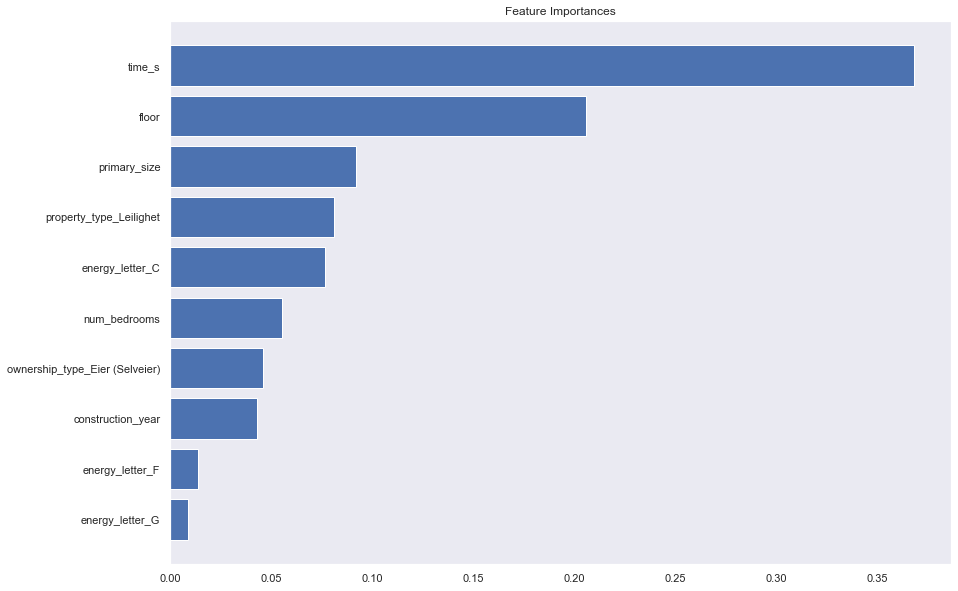

In [256]:
top_n = 10
to_plot = feature_importances[-10:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [257]:
# scipy.sparse.hstack

# Predict Price With NLP

In [258]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [259]:
stop_words = ['av', 'og', 'til', 'over', 'fra', 'om',
              'den', 'det', 'denne', 'dette', 'ved',
              'in', 'inn', 'en', 'opp', 'ikke', 'oss',
              'for', 'du', 'fortsatt', 'flere', 'eller',
              'hele', 'her', 'men', 'kan', 'meget',
              'ingen', 'inntil']

real_estate_terms = ['solgt', 'informasjon', 'bygget',
                     'leiligheter', 'salg', 'solgte', 'bell']

other_terms = ['inkl', 'nn', 'dok', 'str', 'avg', 'yt',
               'kl', 'kj', 'hj', 'schl', 'nyg']

stop_words = stop_words + real_estate_terms + other_terms

In [260]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                   token_pattern = r'[A-z\-]{3,}',
                                   strip_accents=None,
                                   lowercase=True,
                                   stop_words=stop_words,
                                   #vocabulary=
                                   min_df=2,
                                   max_features = 5000)

In [261]:
y = model_data[model_data.index.isin(model_data.index)][target]

In [262]:
y.shape

(1604,)

In [263]:
vectorized_full_desc = count_vectorizer.fit_transform(data_random_one_from_new_buildings[data_random_one_from_new_buildings.index.isin(model_data.index)].short_description)

NameError: name 'data_random_one_from_new_buildings' is not defined

In [ ]:
tfidf_transformer = TfidfTransformer()

In [ ]:
tfidf_full_desc = tfidf_transformer.fit_transform(vectorized_full_desc)

In [ ]:
tfidf_full_desc

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_full_desc, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [ ]:
estimator = AdaBoostRegressor(random_state=random_seed)

In [ ]:
estimator.fit(X_train, y_train)

In [ ]:
y_pred = estimator.predict(X_test)

In [ ]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [ ]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [ ]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [ ]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)

In [ ]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()))

In [ ]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With All Features

In [ ]:
# all_features = scipy.sparse.hstack([vectorized_full_desc, X])
all_features = scipy.sparse.hstack([tfidf_full_desc, X])

In [ ]:
all_features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_features, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [ ]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

In [ ]:
feature_importances = pd.Series(pipeline.named_steps['ada'].feature_importances_, index=list(count_vectorizer.vocabulary_.keys()) + list(x_cols)).sort_values(ascending=True)

In [ ]:
feature_importances.sort_values(ascending=False)[:30]

In [ ]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [ ]:
vocab = pd.Series(list(count_vectorizer.vocabulary_.values()), index=count_vectorizer.vocabulary_.keys())

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(pipeline,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [ ]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [ ]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)